In [256]:
from scipy.optimize import linprog
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

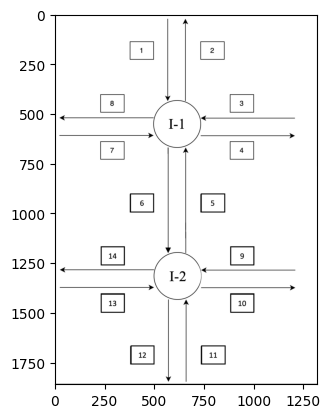

In [257]:
# two intersection graph model to simulate results
graphModel = mpimg.imread('road_network_graph.png')
plt.imshow(graphModel)

In [258]:
# this function returns time required in seconds to clear traffic on road with weight w (w indicates amount of waiting vehicles on road)
# phase of 120 seconds is recommended by USA Transportation research board
# so each combination gets 24-30 seconds
def time_for_vehicles_to_clear_intersection(w):
    # assuming the gap at intersection = 0.01 miles
    intersection_gap = 0.01

    # assuming the speed of vehicles is the road speed limit = 35 mph city roads (excluding interstates)
    # speed in miles per second
    speed_of_vehicles = 35 / 3600

    time_to_clear_intersection = w * (intersection_gap/speed_of_vehicles)

    # the synchornized traffic system optimize based on minimum time required to clear traffic flow
    return min(30, time_to_clear_intersection)

In [259]:
#This function clears Traffic on Edge x with Weight w
#Return time required to clears Traffic with Weight w  on Road Edge x
def clear_traffic_on_edge(x,w):
    time  = time_for_vehicles_to_clear_intersection(w)
    #print("Time to clear edge "+x+" = "+str(time))
    return time

In [260]:
#Weights on Edges Indicating Vehicles on Road
#Ignoring Weights on Edges for Right Lane, assuming Right Lane is Free to Go

w_1_l = 10
w_1_c = 8
w_2_l = 0
w_2_c = 0
w_3_l = 15
w_3_c = 17
w_4_l = 0
w_4_c = 0
w_5_l = 18
w_5_c = 16
w_6_l = 0
w_6_c = 0
w_7_l = 5
w_7_c = 7
w_8_l = 0
w_8_c = 0
w_9_l = 5
w_9_c = 7
w_10_l = 0
w_10_c = 0
w_11_l = 6
w_11_c = 14
w_12_l = 0
w_12_c = 0
w_13_l = 15
w_13_c = 7
w_14_l = 0
w_14_c = 0

In [261]:
# variables for ILP
# 8 variables per intersection
# 1, 3, 5, 7 variables indicate inflow traffic, variables which are to be optimized
# 2, 4, 6, 8 variables doesnt matter at this time, as we are only solving the max traffic clearing one intersection 
# and ignoring the fact that the traffic cleared at one intersection will pool up at next edge
x_1_l = 0
x_1_c = 0
x_2_l = 0
x_2_c = 0
x_3_l = 0
x_3_c = 0
x_4_l = 0
x_4_c = 0
x_5_l = 0
x_5_c = 0
x_6_l = 0
x_6_c = 0
x_7_l = 0
x_7_c = 0
x_8_l = 0
x_8_c = 0
x_9_l = 0
x_9_c = 0
x_10_l = 0
x_10_c = 0
x_11_l = 0
x_11_c = 0
x_12_l = 0
x_12_c = 0
x_13_l = 0
x_13_c = 0
x_14_l = 0
x_14_c = 0

In [262]:
# priority constants k for edges such that it ensures two things
# one, it ensures synchronization is given priority
# two, it also ensures edge activations are stalled, or aligned to same road after every cycle
# case one is observed below
# case two is not observed as the simulation doesnt assume the traffic gets updated on roads after every cycle

k_1_c = 1
k_3_c = 1
k_5_c = 1
k_7_c = 1
k_1_l = 1
k_3_l = 1
k_5_l = 1
k_7_l = 1

k_6_c = 1
k_9_c = 1
k_11_c = 1
k_13_c = 1
k_6_l = 1
k_9_l = 1
k_11_l = 1
k_13_l = 1

In [263]:
def traffic_optimization_model_ILP(w_1_c, w_3_c, w_5_c, w_7_c, w_1_l, w_3_l, w_5_l, w_7_l, k_1_c, k_3_c, k_5_c, k_7_c, k_1_l, k_3_l, k_5_l, k_7_l):
    # objective for Intersection I-1
    # objective -> (w_1_c * x_1_c) + (w_3_c * x_3_c) + (w_5_c * x_5_c) + (w_7_c * x_7_c) + (w_1_l * x_1_l) + (w_3_l * x_3_l) + (w_5_l * x_5_l) + (w_7_l * x_7_l) -> MAX
    
    objective = [-1*w_1_c*k_1_c, -1*w_3_c*k_3_c, -1*w_5_c*k_5_c, -1*w_7_c*k_7_c, -1*w_1_l*k_1_l, -1*w_3_l*k_3_l, -1*w_5_l*k_5_l, -1*w_7_l*k_7_l]

    # variables order
    # x_1_c, x_3_c, x_5_c, x_7_c, x_1_l, x_3_l, x_5_l, x_7_l

    # constraints for Intersection I-1
    # 3 major constraits to avoid collison
    # C1 : avoid straight traffic - straight traffic flow collisions
    # C2 : avoid straight traffic - left traffic flow collisions
    # C3 : avoid left traffic flow - left traffic flow collisions
    lhs_inequality = []
    rhs_inequality = []

    # Constraint 1 (C1) : adjacent inflow edges both cannot go straight at same time
    # C1 - 1 : for edge 1 and its adjacent edges (3,7)
    # x_1_c + x_3_c <= 1
    lhs_inequality.append([1,1,0,0,0,0,0,0])
    rhs_inequality.append(1)

    # x_1_c + x_7_c <= 1
    lhs_inequality.append([1,0,0,1,0,0,0,0])
    rhs_inequality.append(1)

    # C1 - 3 : for edge 3 and its adjacent edges (1,5)
    # x_1_c + x_3_c <= 1
    # covered above C1 - 1

    # x_3_c + x_5_c <= 1
    lhs_inequality.append([0,1,1,0,0,0,0,0])
    rhs_inequality.append(1)

    # C1 - 5 : for edge 5 and its adjacent edges (3,7)
    # x_3_c + x_5_c <= 1
    # covered above C1 - 3

    # x_5_c + x_7_c <= 1
    lhs_inequality.append([0,0,1,1,0,0,0,0])
    rhs_inequality.append(1)

    # C1 - 7 : for edge 7 and its adjacent edges (1,5)
    # x_1_c + x_7_c <= 1
    # covered above C1 - 1

    # x_5_c + x_7_c <= 1
    # covered above C1 - 5

    # Constraint 2 (C2) : one edge straight and all other possible edges that cannot go left
    # C2 - 1 : for edge 1 and its possible left allowed edges (7, 5)
    # x_1_c + x_7_l <= 1
    lhs_inequality.append([1,0,0,0,0,0,0,1])
    rhs_inequality.append(1)

    # x_1_c + x_5_l <= 1
    lhs_inequality.append([1,0,0,0,0,0,1,0])
    rhs_inequality.append(1)

    # C2 - 3 : for edge 3 and its possible left allowed edges (1, 7)
    # x_3_c + x_1_l <= 1
    lhs_inequality.append([0,1,0,0,1,0,0,0])
    rhs_inequality.append(1)

    # x_3_c + x_7_l <= 1
    lhs_inequality.append([0,1,0,0,0,0,0,1])
    rhs_inequality.append(1)

    # C2 - 5 : for edge 5 and its possible left allowed edges (3, 1)
    # x_5_c + x_3_l <= 1
    lhs_inequality.append([0,0,1,0,0,1,0,0])
    rhs_inequality.append(1)

    # x_5_c + x_1_l <= 1
    lhs_inequality.append([0,0,1,0,1,0,0,0])
    rhs_inequality.append(1)

    # C2 - 7 : for edge 7 and its possible left allowed edges (5, 3)
    # x_7_c + x_5_l <= 1
    lhs_inequality.append([0,0,0,1,0,0,1,0])
    rhs_inequality.append(1)

    # x_7_c + x_3_l <= 1
    lhs_inequality.append([0,0,0,1,0,1,0,0])
    rhs_inequality.append(1)

    # Constraint 3 (C3) : edge and its anticlock adjacent edge both cannot go left at same time
    # C3 - 1 : for edge 1 and its anticlock adjacent edges (7)
    # x_1_l + x_7_l <= 1
    lhs_inequality.append([0,0,0,0,1,0,0,1])
    rhs_inequality.append(1)

    # C3 - 3 : for edge 3 and its anticlock adjacent edges (1)
    # x_3_l + x_1_l <= 1
    lhs_inequality.append([0,0,0,0,1,1,0,0])
    rhs_inequality.append(1)

    # C3 - 5 : for edge 5 and its anticlock adjacent edges (3)
    # x_5_l + x_3_l <= 1
    lhs_inequality.append([0,0,0,0,0,1,1,0])
    rhs_inequality.append(1)

    # C3 - 7 : for edge 7 and its anticlock adjacent edges (5)
    # x_7_l + x_5_l <= 1
    lhs_inequality.append([0,0,0,0,0,0,1,1])
    rhs_inequality.append(1)

    
    opt = linprog(c = objective, A_ub = lhs_inequality, b_ub = rhs_inequality, method = 'highs', integrality = [1, 1, 1, 1, 1, 1, 1, 1])
    return opt.x


In [264]:
def display_optimal_signal_setting_at_intersection_1(signal_setting):
    print("Optimal Signal Setting for Intersection I-1")
    for i in range(0,8):
        if i >= 0 and i <= 3:
            if i == 0:
                print("x_1_c = "+str(int(signal_setting[i])))
            elif i == 1:
                print("x_3_c = "+str(int(signal_setting[i])))
            elif i == 2:
                print("x_5_c = "+str(int(signal_setting[i])))
            elif i == 3:
                print("x_7_c = "+str(int(signal_setting[i])))
        else:
            if i == 4:
                print("x_1_l = "+str(int(signal_setting[i])))
            elif i == 5:
                print("x_3_l = "+str(int(signal_setting[i])))
            elif i == 6:
                print("x_5_l = "+str(int(signal_setting[i])))
            elif i == 7:
                print("x_7_l = "+str(int(signal_setting[i])))

def display_optimal_signal_setting_at_intersection_2(signal_setting):
    print("Optimal Signal Setting for Intersection I-2")
    for i in range(0,8):
        if i >= 0 and i <= 3:
            if i == 0:
                print("x_6_c = "+str(int(signal_setting[i])))
            elif i == 1:
                print("x_9_c = "+str(int(signal_setting[i])))
            elif i == 2:
                print("x_11_c = "+str(int(signal_setting[i])))
            elif i == 3:
                print("x_13_c = "+str(int(signal_setting[i])))
        else:
            if i == 4:
                print("x_6_l = "+str(int(signal_setting[i])))
            elif i == 5:
                print("x_9_l = "+str(int(signal_setting[i])))
            elif i == 6:
                print("x_11_l = "+str(int(signal_setting[i])))
            elif i == 7:
                print("x_13_l = "+str(int(signal_setting[i])))

In [265]:
time = 0

signal_setting_I_1 = traffic_optimization_model_ILP(w_1_c, w_3_c, w_5_c, w_7_c, w_1_l, w_3_l, w_5_l, w_7_l, k_1_c, k_3_c, k_5_c, k_7_c, k_1_l, k_3_l, k_5_l, k_7_l)
display_optimal_signal_setting_at_intersection_1(signal_setting_I_1)

signal_setting_I_2 = traffic_optimization_model_ILP(w_6_c, w_9_c, w_11_c, w_13_c, w_6_l, w_9_l, w_11_l, w_13_l, k_6_c, k_9_c, k_11_c, k_13_c, k_6_l, k_9_l, k_11_l, k_13_l)
display_optimal_signal_setting_at_intersection_2(signal_setting_I_2)

Optimal Signal Setting for Intersection I-1
x_1_c = 0
x_3_c = 1
x_5_c = 0
x_7_c = 0
x_1_l = 0
x_3_l = 0
x_5_l = 1
x_7_l = 0
Optimal Signal Setting for Intersection I-2
x_6_c = 0
x_9_c = 0
x_11_c = 1
x_13_c = 0
x_6_l = 0
x_9_l = 0
x_11_l = 0
x_13_l = 1


In [266]:
time_I1_1 = clear_traffic_on_edge("x_3_c", w_3_c)
w_3_c = 0
print("Time(seconds) for edge x_3_c to be cleared at Intersection I1 = "+str(time_I1_1))

time_I1_2 = clear_traffic_on_edge("x_5_l", w_5_l)
w_5_l = 0
print("Time(seconds) for edge x_5_l to be cleared at Intersection I1 = "+str(time_I1_2))

time_I2_1 = clear_traffic_on_edge("x_13_l", w_13_l)
w_13_l = 0
print("Time(seconds) for edge x_13_l to be cleared at Intersection I2 = "+str(time_I2_1))

time_I2_2 = clear_traffic_on_edge("x_11_c", w_11_c)
w_11_c = 0
print("Time(seconds) for edge x_11_c to be cleared at Intersection I2 = "+str(time_I2_2))

# max time for this combination to be cleared
time = time + max(time_I1_1, time_I1_2, time_I2_1, time_I2_2)
print("Max time(seconds) for edge x_3_c,x_5_l,x_11_c,x_13_l to be cleared at Intersection I1 and I2 = "+str(time))

Time(seconds) for edge x_3_c to be cleared at Intersection I1 = 17.485714285714284
Time(seconds) for edge x_5_l to be cleared at Intersection I1 = 18.514285714285712
Time(seconds) for edge x_13_l to be cleared at Intersection I2 = 15.428571428571427
Time(seconds) for edge x_11_c to be cleared at Intersection I2 = 14.399999999999999
Max time(seconds) for edge x_3_c,x_5_l,x_11_c,x_13_l to be cleared at Intersection I1 and I2 = 18.514285714285712


In [267]:

signal_setting_I_1 = traffic_optimization_model_ILP(w_1_c, w_3_c, w_5_c, w_7_c, w_1_l, w_3_l, w_5_l, w_7_l, k_1_c, k_3_c, k_5_c, k_7_c, k_1_l, k_3_l, k_5_l, k_7_l)
display_optimal_signal_setting_at_intersection_1(signal_setting_I_1)

Optimal Signal Setting for Intersection I-1
x_1_c = 1
x_3_c = 0
x_5_c = 1
x_7_c = 0
x_1_l = 0
x_3_l = 0
x_5_l = 0
x_7_l = 0


In [268]:
time_I1_1 = clear_traffic_on_edge("x_1_c", w_1_c)
w_6_c = w_1_c # this ensures the synchronized path 1 -> 6 -> 12 gets enabled by the traffic signal system
k_6_c = k_6_c * 10 # edge 6 given priority to 
w_1_c = 0
print("Time(seconds) for edge x_1_c to be cleared at Intersection I1 = "+str(time_I1_1))

# SYNCHRONIZATION STEP
# now we try to prioritize the x_6_c edge with higher priority and ensure the signal at Intersection I - 2 is enabled to clear this traffic
signal_setting_I_2 = traffic_optimization_model_ILP(w_6_c, w_9_c, w_11_c, w_13_c, w_6_l, w_9_l, w_11_l, w_13_l, k_6_c, k_9_c, k_11_c, k_13_c, k_6_l, k_9_l, k_11_l, k_13_l)
display_optimal_signal_setting_at_intersection_2(signal_setting_I_2)

# parallely the edge x_6_c gets activated due to higher priority during this time
time_I2_1 = clear_traffic_on_edge("x_6_c", w_6_c)
time_I2_2 = clear_traffic_on_edge("x_9_l", w_9_l)
print("Time(seconds) for edge x_6_c to be cleared at Intersection I2 = "+str(time_I2_1))
print("Time(seconds) for edge x_9_l to be cleared at Intersection I2 = "+str(time_I2_2))
w_6_c = 0
w_9_l = 0

time_I1_2 = clear_traffic_on_edge("x_5_c", w_5_c)
w_5_c = 0
print("Time(seconds) for edge x_5_c to be cleared at Intersection I1 = "+str(time_I1_2))

# max time for this combination to be cleared
time = time + max(time_I1_1, time_I1_2, time_I2_1, time_I2_2)
print("Max time(seconds) for edge x_1_c,x_5_c,x_6_c,x_9_l to be cleared at Intersection I1 and I2 = "+str(time))

Time(seconds) for edge x_1_c to be cleared at Intersection I1 = 8.228571428571428
Optimal Signal Setting for Intersection I-2
x_6_c = 1
x_9_c = 0
x_11_c = 0
x_13_c = 0
x_6_l = 0
x_9_l = 1
x_11_l = 0
x_13_l = 0
Time(seconds) for edge x_6_c to be cleared at Intersection I2 = 8.228571428571428
Time(seconds) for edge x_9_l to be cleared at Intersection I2 = 5.142857142857142
Time(seconds) for edge x_5_c to be cleared at Intersection I1 = 16.457142857142856
Max time(seconds) for edge x_1_c,x_5_c,x_6_c,x_9_l to be cleared at Intersection I1 and I2 = 34.97142857142857


In [269]:
signal_setting_I_1 = traffic_optimization_model_ILP(w_1_c, w_3_c, w_5_c, w_7_c, w_1_l, w_3_l, w_5_l, w_7_l, k_1_c, k_3_c, k_5_c, k_7_c, k_1_l, k_3_l, k_5_l, k_7_l)
display_optimal_signal_setting_at_intersection_1(signal_setting_I_1)

signal_setting_I_2 = traffic_optimization_model_ILP(w_6_c, w_9_c, w_11_c, w_13_c, w_6_l, w_9_l, w_11_l, w_13_l, k_6_c, k_9_c, k_11_c, k_13_c, k_6_l, k_9_l, k_11_l, k_13_l)
display_optimal_signal_setting_at_intersection_2(signal_setting_I_2)

Optimal Signal Setting for Intersection I-1
x_1_c = 0
x_3_c = 0
x_5_c = 0
x_7_c = 0
x_1_l = 0
x_3_l = 1
x_5_l = 0
x_7_l = 1
Optimal Signal Setting for Intersection I-2
x_6_c = 0
x_9_c = 1
x_11_c = 0
x_13_c = 1
x_6_l = 0
x_9_l = 0
x_11_l = 0
x_13_l = 0


In [270]:
time_I1_1 = clear_traffic_on_edge("x_3_l", w_3_l)
w_3_l = 0
print("Time(seconds) for edge x_3_l to be cleared at Intersection I1 = "+str(time_I1_1))

time_I1_2 = clear_traffic_on_edge("x_7_l", w_7_l)
w_7_l = 0
print("Time(seconds) for edge x_7_l to be cleared at Intersection I1 = "+str(time_I1_2))

time_I2_1 = clear_traffic_on_edge("x_13_c", w_13_c)
w_13_c = 0
print("Time(seconds) for edge x_13_c to be cleared at Intersection I2 = "+str(time_I2_1))

time_I2_2 = clear_traffic_on_edge("x_9_c", w_9_c)
w_9_c = 0
print("Time(seconds) for edge x_9_c to be cleared at Intersection I2 = "+str(time_I2_2))

# max time for this combination to be cleared
time = time + max(time_I1_1, time_I1_2, time_I2_1, time_I2_2)
print("Max time(seconds) for edge x_3_l,x_7_l,x_13_c,x_9_c to be cleared at Intersection I1 and I2 = "+str(time))

Time(seconds) for edge x_3_l to be cleared at Intersection I1 = 15.428571428571427
Time(seconds) for edge x_7_l to be cleared at Intersection I1 = 5.142857142857142
Time(seconds) for edge x_13_c to be cleared at Intersection I2 = 7.199999999999999
Time(seconds) for edge x_9_c to be cleared at Intersection I2 = 7.199999999999999
Max time(seconds) for edge x_3_l,x_7_l,x_13_c,x_9_c to be cleared at Intersection I1 and I2 = 50.39999999999999


In [271]:
signal_setting_I_1 = traffic_optimization_model_ILP(w_1_c, w_3_c, w_5_c, w_7_c, w_1_l, w_3_l, w_5_l, w_7_l, k_1_c, k_3_c, k_5_c, k_7_c, k_1_l, k_3_l, k_5_l, k_7_l)
display_optimal_signal_setting_at_intersection_1(signal_setting_I_1)

signal_setting_I_2 = traffic_optimization_model_ILP(w_6_c, w_9_c, w_11_c, w_13_c, w_6_l, w_9_l, w_11_l, w_13_l, k_6_c, k_9_c, k_11_c, k_13_c, k_6_l, k_9_l, k_11_l, k_13_l)
display_optimal_signal_setting_at_intersection_2(signal_setting_I_2)

Optimal Signal Setting for Intersection I-1
x_1_c = 0
x_3_c = 0
x_5_c = 0
x_7_c = 1
x_1_l = 1
x_3_l = 0
x_5_l = 0
x_7_l = 0
Optimal Signal Setting for Intersection I-2
x_6_c = 0
x_9_c = 0
x_11_c = 0
x_13_c = 0
x_6_l = 0
x_9_l = 0
x_11_l = 1
x_13_l = 0


In [272]:
time_I1_1 = clear_traffic_on_edge("x_7_c", w_7_c)
w_7_c = 0
print("Time(seconds) for edge x_7_c to be cleared at Intersection I1 = "+str(time_I1_1))

time_I1_2 = clear_traffic_on_edge("x_1_l", w_1_l)
w_1_l = 0
print("Time(seconds) for edge x_1_l to be cleared at Intersection I1 = "+str(time_I1_2))

time_I2_1 = clear_traffic_on_edge("x_11_l", w_11_l)
w_11_l = 0
print("Time(seconds) for edge x_11_l to be cleared at Intersection I2 = "+str(time_I2_1))


# max time for this combination to be cleared
time = time + max(time_I1_1, time_I1_2, time_I2_1, time_I2_2)
print("Max time(seconds) for edge x_7_c,x_1_l,x_11_l to be cleared at Intersection I1 and I2 = "+str(time))

Time(seconds) for edge x_7_c to be cleared at Intersection I1 = 7.199999999999999
Time(seconds) for edge x_1_l to be cleared at Intersection I1 = 10.285714285714285
Time(seconds) for edge x_11_l to be cleared at Intersection I2 = 6.171428571428571
Max time(seconds) for edge x_7_c,x_1_l,x_11_l to be cleared at Intersection I1 and I2 = 60.685714285714276


In [273]:
signal_setting_I_1 = traffic_optimization_model_ILP(w_1_c, w_3_c, w_5_c, w_7_c, w_1_l, w_3_l, w_5_l, w_7_l, k_1_c, k_3_c, k_5_c, k_7_c, k_1_l, k_3_l, k_5_l, k_7_l)
display_optimal_signal_setting_at_intersection_1(signal_setting_I_1)

signal_setting_I_2 = traffic_optimization_model_ILP(w_6_c, w_9_c, w_11_c, w_13_c, w_6_l, w_9_l, w_11_l, w_13_l, k_6_c, k_9_c, k_11_c, k_13_c, k_6_l, k_9_l, k_11_l, k_13_l)
display_optimal_signal_setting_at_intersection_2(signal_setting_I_2)

Optimal Signal Setting for Intersection I-1
x_1_c = 0
x_3_c = 0
x_5_c = 0
x_7_c = 0
x_1_l = 0
x_3_l = 0
x_5_l = 0
x_7_l = 0
Optimal Signal Setting for Intersection I-2
x_6_c = 0
x_9_c = 0
x_11_c = 0
x_13_c = 0
x_6_l = 0
x_9_l = 0
x_11_l = 0
x_13_l = 0


In [274]:
# end of program as all traffic has been cleared